In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go

In [2]:
train_raw = pd.read_csv('train.csv', index_col = 'Date', parse_dates = True)
stores_raw = pd.read_csv('stores.csv')
features_raw = pd.read_csv('features.csv', index_col = 'Date', parse_dates = True)
test_raw = pd.read_csv('test.csv', index_col = 'Date', parse_dates = True)
names_raw = pd.read_csv('Walmart_Department_Name.csv')
train = train_raw.copy()
stores = stores_raw.copy()
features = features_raw.copy()
test = test_raw.copy()
names = names_raw.copy()

In [3]:
holidays = pd.DataFrame({'Holiday': ['Super Bowl', 'Labor Day', 'Thanksgiving', 'Christmas', 'Super Bowl', 'Labor Day', 'Thanksgiving', 'Christmas', 'Super Bowl', 'Labor Day']},
                        index = train.loc[train.IsHoliday == True].index.unique())

In [4]:
dept_names = pd.merge(train, names, left_on = 'Dept', right_on = 'Id').drop('Id', axis = 1)
dept_names = pd.merge(dept_names, stores, on = 'Store')

In [5]:
dept_names.head()

,Store,Dept,Weekly_Sales,IsHoliday,Name,Type,Size
0,1,1,24924.50,False,Candy and Tobacco,A,151315
1,1,1,46039.49,True,Candy and Tobacco,A,151315
2,1,1,41595.55,False,Candy and Tobacco,A,151315
3,1,1,19403.54,False,Candy and Tobacco,A,151315
4,1,1,21827.90,False,Candy and Tobacco,A,151315


Checking out major peaks

In [6]:
def holiday_trend(department):
    fig, ax = plt.subplots(figsize = (20, 5))
    temp = train.loc[(train.Store == 1) & (train.Dept == department)]['Weekly_Sales']
    plt.plot(temp.index, temp.values, alpha = 1)
    plt.vlines(x = holidays.index, ymin = temp.min(), ymax = temp.max(), linestyles = 'dashed', color = 'grey', linewidth = 0.5)
    for i, j in zip(holidays.index, holidays.values):
        plt.text(x = i + pd.DateOffset(days = 3), y = temp.quantile(0.95), s = j[0], rotation = 90, fontsize = 'small', alpha = 0.5, color = 'red')

In [7]:
widgets.interact(holiday_trend, department = train.loc[train.Store == 1]['Dept'].unique());

interactive(children=(Dropdown(description='department', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

Analyzing individual holidays

In [8]:
holidays

,Holiday
Date,
2010-02-12,Super Bowl
2010-09-10,Labor Day
2010-11-26,Thanksgiving
2010-12-31,Christmas
2011-02-11,Super Bowl
2011-09-09,Labor Day
2011-11-25,Thanksgiving
2011-12-30,Christmas
2012-02-10,Super Bowl


In [9]:
christmas1 = train['2010-12-01':'2011-02-01'] #Christmas +/- 2 weeks
christmas2 = train['2011-12-01':'2012-02-01']

In [10]:
def christmas_trend(department = 1):
    fig, ax = plt.subplots(1, 2, figsize = (15, 4))
    temp1 = christmas1.loc[(christmas1.Store == 1) & (christmas1.Dept == department)]['Weekly_Sales']
    temp2 = christmas2.loc[(christmas2.Store == 1) & (christmas2.Dept == department)]['Weekly_Sales']
    sns.lineplot(data = temp1, ax = ax[0])
    ax[0].tick_params(axis = 'x', rotation = 30)
    ax[0].set_title('2010 Christmas')
    sns.lineplot(data = temp2, ax = ax[1])
    ax[1].tick_params(axis = 'x', rotation = 30)
    ax[1].set_title('2011 Christmas')
    fig.suptitle(f"Department: {names.loc[names.Id == department]['Name'].values[0]}")

In [11]:
widgets.interact(christmas_trend, department = train.loc[train.Store == 1]['Dept'].unique());

interactive(children=(Dropdown(description='department', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

Plotly graph - holiday trend for store 1

In [12]:
def plotly_holiday_trend(department = 1):
    temp = train.loc[(train.Store == 1) & (train.Dept == department)]['Weekly_Sales']
    fig = px.line(data_frame = temp, x = temp.index, y = temp.values, title = f"{names.loc[names.Id == department]['Name'].values[0]}")
    fig.update_layout(width = 1380, height = 450, paper_bgcolor="white")
    for i in holidays.index:
        fig.add_vline(i, line_dash="dash", line_color="green")
    for i, j in zip(holidays.index + pd.DateOffset(days = 5), holidays.Holiday):
        fig.add_annotation(text=f"{j}",
                      xref="x", yref="paper",
                      x=i, y=0.98, showarrow=False, textangle = -90, font=dict(family="Courier New, monospace",size=12,color="red"))
    fig.show()

In [13]:
widgets.interact(plotly_holiday_trend, department = train.loc[train.Store == 1]['Dept'].unique());

interactive(children=(Dropdown(description='department', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

Is the influence of holiday statistically significant for sales?

In [14]:
from scipy.stats import f_oneway

In [15]:
_, p_value = f_oneway(train.loc[train.IsHoliday == False]['Weekly_Sales'].values, train.loc[train.IsHoliday == True]['Weekly_Sales'].values)

In [16]:
p_value # less than 0.05 therefore significant

1.091222267254605e-16

In [17]:
holiday_df = train.loc[holidays.index]

In [18]:
holiday_df.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-12,1,1,46039.49,True
2010-02-12,1,2,44682.74,True
2010-02-12,1,3,10887.84,True
2010-02-12,1,4,35351.21,True
2010-02-12,1,5,29620.81,True


In [19]:
x = holiday_df.groupby(holiday_df.index)['Weekly_Sales'].sum().to_frame()

In [20]:
x['Year'] = x.index.year

In [21]:
x = pd.concat([x, holidays.Holiday], axis = 1)

In [22]:
x = x.iloc[:8,:]

In [23]:
x

,Weekly_Sales,Year,Holiday
Date,,,
2010-02-12,48336677.63,2010,Super Bowl
2010-09-10,45634397.84,2010,Labor Day
2010-11-26,65821003.24,2010,Thanksgiving
2010-12-31,40432519.00,2010,Christmas
2011-02-11,47336192.79,2011,Super Bowl
2011-09-09,46763227.53,2011,Labor Day
2011-11-25,66593605.26,2011,Thanksgiving
2011-12-30,46042461.04,2011,Christmas


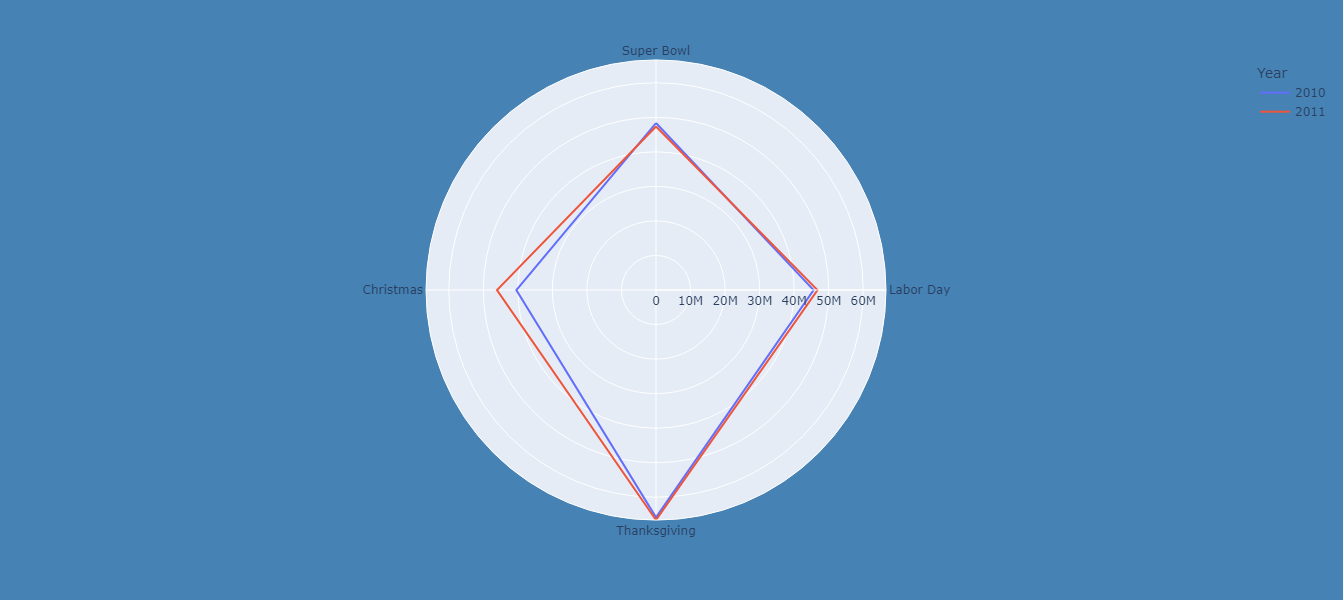

In [24]:
fig = px.line_polar(x, r='Weekly_Sales', theta='Holiday', color = 'Year', line_close=True)
fig.update_layout(width = 600, height = 600, paper_bgcolor="steelblue")
fig.show()

### Exclude abnormal days like the week before christmas, near holidays etc and try to do a distribution plot (do it using z score)

### Use abnormal removed weeks in modelling a linear or non linear relation bw temp and sales, use LinearRegression method and plot residual plot to check heteroskedasticity

In [25]:
train

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False
...,...,...,...,...
2012-09-28,45,98,508.37,False
2012-10-05,45,98,628.10,False
2012-10-12,45,98,1061.02,False


In [26]:
train.Weekly_Sales.describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

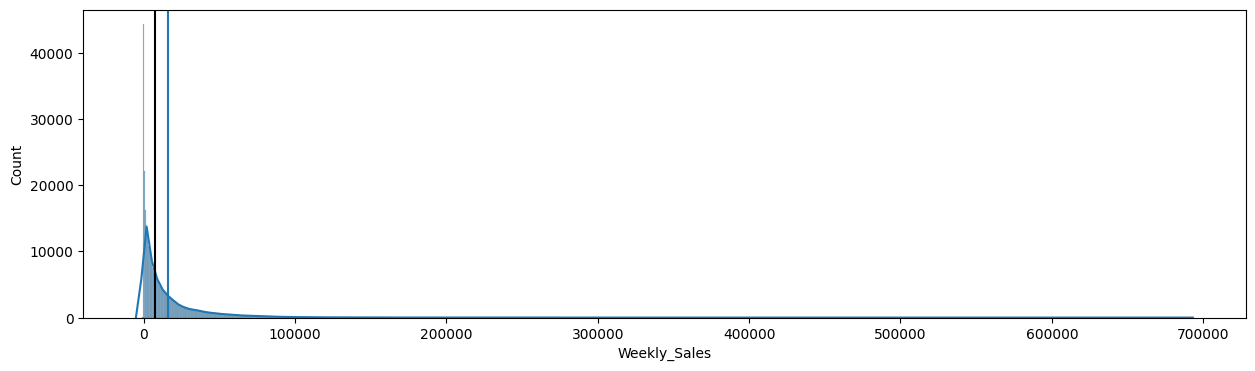

In [27]:
fig, ax = plt.subplots(figsize = (15, 4))
sns.histplot(train.Weekly_Sales, kde = True)
plt.axvline(x = train.Weekly_Sales.mean())
plt.axvline(x = train.Weekly_Sales.median(), color = 'black')

<Axes: xlabel='Weekly_Sales'>

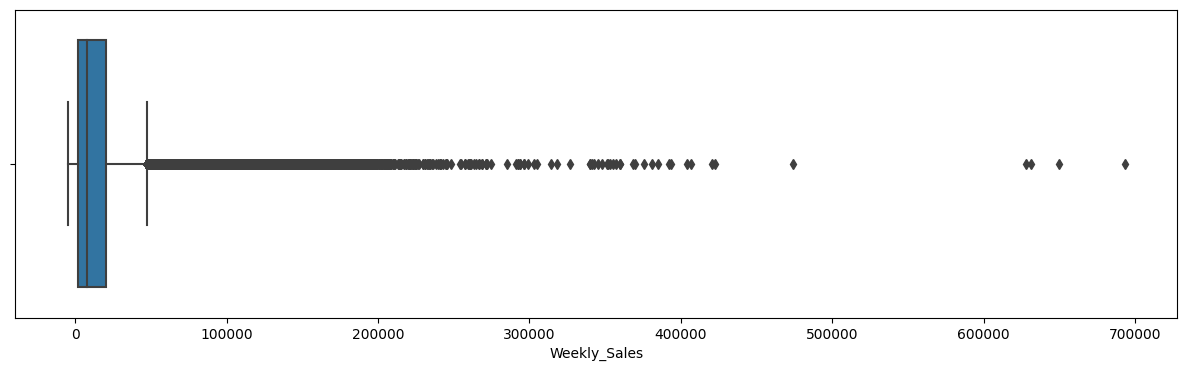

In [28]:
fig, ax = plt.subplots(figsize = (15, 4))
sns.boxplot(x = train.Weekly_Sales, orient = 'h')
# fig = px.box(data_frame = train, x = 'Weekly_Sales')
# fig.update_layout(width = 1380, height = 450, paper_bgcolor="white")
# fig.show()

In [29]:
holidays

,Holiday
Date,
2010-02-12,Super Bowl
2010-09-10,Labor Day
2010-11-26,Thanksgiving
2010-12-31,Christmas
2011-02-11,Super Bowl
2011-09-09,Labor Day
2011-11-25,Thanksgiving
2011-12-30,Christmas
2012-02-10,Super Bowl


In [30]:
store_weekly_sales = train.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
features1 = features_raw[['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']]
features1 = features1['2010-02-05':'2012-10-26']
overall = pd.merge(store_weekly_sales, features1, left_on = ['Date', 'Store'], right_on = [features1.index, 'Store'])
overall = overall.set_index('Date')

In [44]:
def overall_ts(store):
    fig, ax = plt.subplots(figsize = (25, 5))
    temp = overall.loc[overall.Store == store]['Weekly_Sales']
    sns.lineplot(x = temp.index, y = temp.values)
    plt.vlines(x = overall.loc[overall.IsHoliday == True].index, ymin = temp.min(), ymax = temp.max(), linestyles = 'dashed', color = 'grey', linewidth = 0.5)
    for i, j in zip(holidays.index, holidays.values):
        plt.text(x = i + pd.DateOffset(days = 3), y = temp.quantile(0.99), s = j[0], rotation = 90, fontsize = 'small', alpha = 1, color = 'red')

In [45]:
widgets.interact(overall_ts, store = overall.Store.unique());

interactive(children=(Dropdown(description='store', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

In [33]:
highest_sales_week = ['2010-12-10', '2011-12-09', '2010-12-17', '2011-12-16', '2010-12-24', '2011-12-23', '2010-12-31', '2011-12-30', '2010-11-26', '2011-11-25',
                     '2010-02-12', '2011-02-11', '2012-02-10', '2010-09-10', '2011-09-09', '2012-09-07']

In [34]:
overall_holiday_removed = overall.copy()

In [35]:
for i in range(1, 46):
    median = overall.loc[overall.Store == i].Weekly_Sales.median()
    for j in highest_sales_week:
        overall_holiday_removed.loc[(overall_holiday_removed.Store == i) & (overall.index == j), 'Weekly_Sales'] = median

In [36]:
def overall_holiday_removed_ts(store):
    fig, ax = plt.subplots(figsize = (16, 4))
    temp = overall_holiday_removed.loc[overall_holiday_removed.Store == store]['Weekly_Sales']
    sns.lineplot(x = temp.index, y = temp.values)
    plt.vlines(x = overall_holiday_removed.loc[overall_holiday_removed.IsHoliday == True].index, 
               ymin = temp.min(), 
               ymax = temp.max(), 
               linestyles = 'dashed', 
               color = 'grey', 
               linewidth = 0.5)
    for i, j in zip(holidays.index, holidays.values):
        plt.text(x = i + pd.DateOffset(days = 3), y = temp.quantile(0.99), s = j[0], rotation = 90, fontsize = 'small', alpha = 1, color = 'red')

In [37]:
widgets.interact(overall_holiday_removed_ts, store = overall.Store.unique());

interactive(children=(Dropdown(description='store', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

In [38]:
def overall_holiday_removed_dist(store = 1):
    fig, ax = plt.subplots(1, 2, figsize = (16, 5))
    st = overall_holiday_removed.loc[overall_holiday_removed.Store == store]['Weekly_Sales']
    sns.histplot(st, kde = True, ax = ax[0], color = 'orange')
    sns.boxplot(st, orient = 'h', ax = ax[1], color = 'green');

In [39]:
widgets.interact(overall_holiday_removed_dist, store = overall_holiday_removed.Store.unique());

interactive(children=(Dropdown(description='store', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…